# Glove - Global Vector for Word Representation

Input data

In [113]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt  # For visualizing results

# Step 1: Build a small corpus and vocabulary
corpus = [
    "the dog sat on the rug",
    "the cat sat on the mat",
    "the cat likes to sit"
]

pd.DataFrame(corpus, columns=["Sentences"])

,Sentences
0,the dog sat on the rug
1,the cat sat on the mat
2,the cat likes to sit


Generating unique vocabulary

In [114]:
# Tokenize and build vocabulary
words = []
for sentence in corpus:
    words.extend(sentence.split())
vocab = list(set(words))
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}
vocab_size = len(vocab)
print(f"Vocabulary: {vocab}")

X = np.zeros((vocab_size, vocab_size))
pd.DataFrame(X, columns=vocab, index=vocab).astype(int)

Vocabulary: ['rug', 'mat', 'sit', 'cat', 'likes', 'sat', 'to', 'on', 'dog', 'the']


,rug,mat,sit,cat,likes,sat,to,on,dog,the
rug,0,0,0,0,0,0,0,0,0,0
mat,0,0,0,0,0,0,0,0,0,0
sit,0,0,0,0,0,0,0,0,0,0
cat,0,0,0,0,0,0,0,0,0,0
likes,0,0,0,0,0,0,0,0,0,0
sat,0,0,0,0,0,0,0,0,0,0
to,0,0,0,0,0,0,0,0,0,0
on,0,0,0,0,0,0,0,0,0,0
dog,0,0,0,0,0,0,0,0,0,0
the,0,0,0,0,0,0,0,0,0,0


 Build co-occurrence matrix

In [115]:
window_size = 1  # Context window size

for sentence in corpus:
    tokens = sentence.split()
    for i, target in enumerate(tokens):
        # Define context window
        start = max(0, i - window_size)
        end = min(len(tokens), i + window_size + 1)
        for j in range(start, end):
            if i != j:  # Skip the target word itself
                context = tokens[j]
                X[word_to_idx[target], word_to_idx[context]] += 1.0
               
import pandas as pd
matrix = pd.DataFrame(X, index=vocab, columns=vocab).astype(int)
matrix

,rug,mat,sit,cat,likes,sat,to,on,dog,the
rug,0,0,0,0,0,0,0,0,0,1
mat,0,0,0,0,0,0,0,0,0,1
sit,0,0,0,0,0,0,1,0,0,0
cat,0,0,0,0,1,1,0,0,0,2
likes,0,0,0,1,0,0,1,0,0,0
sat,0,0,0,1,0,0,0,2,1,0
to,0,0,1,0,1,0,0,0,0,0
on,0,0,0,0,0,2,0,0,0,2
dog,0,0,0,0,0,1,0,0,0,1
the,1,1,0,2,0,0,0,2,1,0


Define Glove model

In [116]:
# GloVe parameters
embedding_dim = 2  # Small dimension for simplicity
learning_rate = 0.05
epochs = 100

# Initialize word and context vectors, biases
np.random.seed(42)
W = np.random.uniform(-0.5, 0.5, (vocab_size, embedding_dim))  # Word vectors
W_tilde = np.random.uniform(-0.5, 0.5, (vocab_size, embedding_dim))  # Context vectors
b = np.random.uniform(-0.5, 0.5, vocab_size)  # Word biases
b_tilde = np.random.uniform(-0.5, 0.5, vocab_size)  # Context biases

# Weighting function f(X_ij)
def weighting_function(x, x_max=100, alpha=0.75):
    if x < x_max:
        # penalize rare events
        return (x / x_max) ** alpha
    # not to overweigh frequent events
    return 1.0

Training GloVe

In [117]:
for epoch in range(epochs):
    total_loss = 0
    for i in range(vocab_size):
        for j in range(vocab_size):
            if X[i, j] > 0:  # Only train on non-zero co-occurrences
                # Compute prediction
                prediction = np.dot(W[i], W_tilde[j]) + b[i] + b_tilde[j]
                log_xij = np.log(X[i, j] + 1e-10)  # Avoid log(0)
                weight = weighting_function(X[i, j])

                # Loss: weighted squared error
                diff = prediction - log_xij
                loss = weight * (diff ** 2)
                total_loss += loss

                # Gradients
                grad = 2 * weight * diff
                W_grad = grad * W_tilde[j]
                W_tilde_grad = grad * W[i]

                # Update parameters
                W[i] -= learning_rate * W_grad
                W_tilde[j] -= learning_rate * W_tilde_grad
                b[i] -= learning_rate * grad
                b_tilde[j] -= learning_rate * grad

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 0.3371
Epoch 10, Loss: 0.2460
Epoch 20, Loss: 0.1858
Epoch 30, Loss: 0.1448
Epoch 40, Loss: 0.1161
Epoch 50, Loss: 0.0954
Epoch 60, Loss: 0.0801
Epoch 70, Loss: 0.0684
Epoch 80, Loss: 0.0593
Epoch 90, Loss: 0.0521


Visual the embeddings


Word Embeddings:
rug: [-0.11582344  0.44656713]
mat: [0.23013787 0.10002544]
sit: [-0.42482394 -0.26797684]
cat: [-0.4533513  0.443899 ]
likes: [0.05835487 0.26116412]
sat: [-0.35312689  0.52231936]
to: [ 0.33365162 -0.2952487 ]
on: [-0.28554392 -0.3473271 ]
dog: [-0.20842715  0.05647238]
the: [ 0.01596369 -0.07537336]


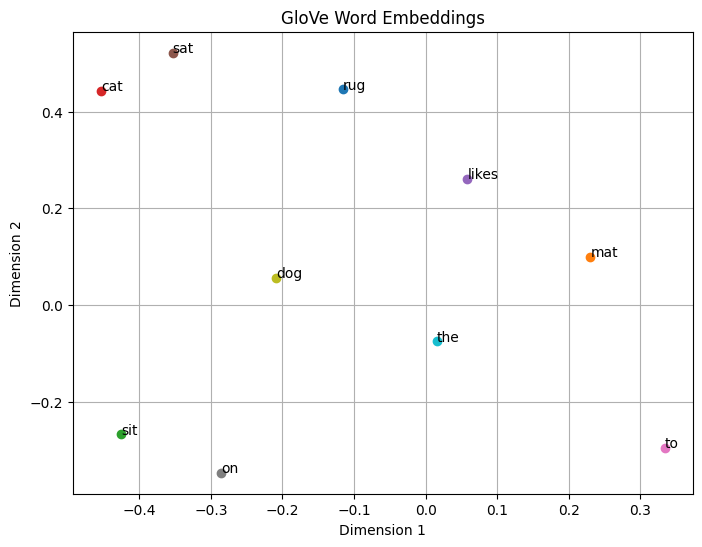

In [118]:
# Step 5: Combine word and context vectors (common practice in GloVe)
#embeddings = (W + W_tilde) / 2
embeddings = W

# Step 6: Display results
print("\nWord Embeddings:")
for i in range(vocab_size):
    print(f"{idx_to_word[i]}: {embeddings[i]}")

# Step 7: Visualize (2D embeddings)
plt.figure(figsize=(8, 6))
for i in range(vocab_size):
    plt.scatter(embeddings[i, 0], embeddings[i, 1])
    plt.annotate(idx_to_word[i], (embeddings[i, 0], embeddings[i, 1]))
plt.title("GloVe Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()